In [1]:
%load_ext autoreload
%autoreload 2

import torch
import ml_collections

import datasets

import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["figure.dpi"] = 110

In [2]:
%conda env list

# conda environments:
#
base                     /Users/smaug/miniforge3
jax-env                  /Users/smaug/miniforge3/envs/jax-env
ml-env                *  /Users/smaug/miniforge3/envs/ml-env
svdd-env                 /Users/smaug/miniforge3/envs/svdd-env


Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Make sure the current PyTorch binary was built with MPS enabled
print(torch.backends.mps.is_built())
# And that the current hardware and MacOS version are sufficient to
# be able to use MPS
print(torch.backends.mps.is_available())

device = torch.device("mps")

torch.__version__

True
True


'1.13.0.dev20220525'

In [5]:
config = ml_collections.ConfigDict()
config.dataset= "credit_fraud"
config.scale = 0.5

In [6]:
X_train, (X_val_in, X_val_out), (X_test_in, X_test_out) = datasets.build_dataset(config, val_ratio=0.2)

In [7]:
from models.simple_nn import SimpleNet

### Simulating a forward step

In [12]:
model = SimpleNet(29, hidden_dim=256)
x_batch = torch.from_numpy(X_val_in[:32]).float()
dummy = torch.zeros_like(x_batch)

In [13]:
%time model(dummy).shape

CPU times: user 423 µs, sys: 269 µs, total: 692 µs
Wall time: 404 µs


torch.Size([32, 29])

In [14]:
device = torch.device("cpu")

In [15]:
model = SimpleNet(29, hidden_dim=256).to(device)
layers = next(model.children())
x_batch = torch.from_numpy(X_val_in[:16]).to(device)
dummy = torch.zeros_like(x_batch, device=device)

In [16]:
ood_batch = torch.from_numpy(X_val_out[:16]).to(device)

In [17]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
SimpleNet                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       7,680
│    └─ELU: 2-2                          --
│    └─Linear: 2-3                       65,792
│    └─ELU: 2-4                          --
│    └─Linear: 2-5                       7,453
Total params: 80,925
Trainable params: 80,925
Non-trainable params: 0

In [18]:
from losses import build_loss_fn

loss_fn  = build_loss_fn(config)

In [19]:
model(dummy).sum(dim=1)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       grad_fn=<SumBackward1>)

In [20]:
%%time
x_pert = dummy + torch.randn_like(dummy) * 0.0
scores =  model(x_pert)
loss=loss_fn(scores, dummy, x_pert)
loss

CPU times: user 691 µs, sys: 1.89 ms, total: 2.58 ms
Wall time: 5.32 ms


tensor(0., grad_fn=<SumBackward0>)

### Karpathy bug test

In [21]:
dummy_batch = torch.ones_like(x_batch[:5], requires_grad = True)

In [22]:
scores = model(dummy_batch)
loss=scores[3].sum()
loss

tensor(-1.4589, grad_fn=<SumBackward0>)

In [23]:
loss.backward()

In [24]:
dummy_batch.grad

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-1.2916, -1.1063, -0.2641,  2.7393,  0.1262, -0.3927,  0.7584,  0.8687,
         -0.4821,  0.6710

In [25]:
layers[0].weight.grad

tensor([[-0.3201, -0.3201, -0.3201,  ..., -0.3201, -0.3201, -0.3201],
        [-0.5786, -0.5786, -0.5786,  ..., -0.5786, -0.5786, -0.5786],
        [-0.1453, -0.1453, -0.1453,  ..., -0.1453, -0.1453, -0.1453],
        ...,
        [-0.2221, -0.2221, -0.2221,  ..., -0.2221, -0.2221, -0.2221],
        [ 0.0435,  0.0435,  0.0435,  ...,  0.0435,  0.0435,  0.0435],
        [ 0.1352,  0.1352,  0.1352,  ...,  0.1352,  0.1352,  0.1352]])

### Overfitting to a small batch

In [78]:
model = SimpleNet(29, hidden_dim=64).to(device)
x_batch = torch.from_numpy(X_val_in[:2]).to(device)

In [79]:
summary(model)

Layer (type:depth-idx)                   Param #
SimpleNet                                --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,920
│    └─ELU: 2-2                          --
│    └─Linear: 2-3                       4,160
│    └─ELU: 2-4                          --
│    └─Linear: 2-5                       1,885
Total params: 7,965
Trainable params: 7,965
Non-trainable params: 0

In [80]:
opt = torch.optim.SGD(model.parameters(), lr=1e-6)
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 1e-06
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [81]:
opt.zero_grad()

In [82]:
# x = torch.ones_like(x_batch, requires_grad=True)
z = torch.randn_like(x_batch, device=device) * config.scale
x_pert = x_batch + z
loss_fn(-z/config.scale**2, x_batch, x_pert)

tensor(5.0465e-13)

In [86]:
%%time
model.train()
losses = []

for i in range(500000):
    opt.zero_grad()
    x_pert = x_batch + torch.randn_like(x_batch, device=device) * config.scale
    scores = model(x_pert)
    loss = loss_fn(scores, x_batch, x_pert)
    loss.backward()
    opt.step()
    
    if i % 1000 == 0:
        losses.append(loss.item())
    
    if i % 10000 == 0: print(f"Iter {i:3d} - Loss: {loss.item():.3f}")

print(f"Iter {i:3d} - Loss: {loss.item():.3f}")

Iter   0 - Loss: 174.762
Iter 10000 - Loss: 126.309
Iter 20000 - Loss: 58.768
Iter 30000 - Loss: 53.726
Iter 40000 - Loss: 62.602
Iter 50000 - Loss: 38.870
Iter 60000 - Loss: 63.323
Iter 70000 - Loss: 43.165
Iter 80000 - Loss: 31.463
Iter 90000 - Loss: 27.371
Iter 100000 - Loss: 31.694
Iter 110000 - Loss: 15.554
Iter 120000 - Loss: 43.649
Iter 130000 - Loss: 38.568
Iter 140000 - Loss: 30.934
Iter 150000 - Loss: 30.140
Iter 160000 - Loss: 7.889
Iter 170000 - Loss: 56.884
Iter 180000 - Loss: 50.925
Iter 190000 - Loss: 18.485
Iter 200000 - Loss: 18.525
Iter 210000 - Loss: 13.530
Iter 220000 - Loss: 37.732
Iter 230000 - Loss: 43.995
Iter 240000 - Loss: 17.845
Iter 250000 - Loss: 30.571
Iter 260000 - Loss: 19.557
Iter 270000 - Loss: 29.664
Iter 280000 - Loss: 13.613
Iter 290000 - Loss: 11.782
Iter 300000 - Loss: 26.487
Iter 310000 - Loss: 9.002
Iter 320000 - Loss: 17.416
Iter 330000 - Loss: 18.084
Iter 340000 - Loss: 7.245
Iter 350000 - Loss: 59.774
Iter 360000 - Loss: 7.000
Iter 370000 - L

<AxesSubplot:>

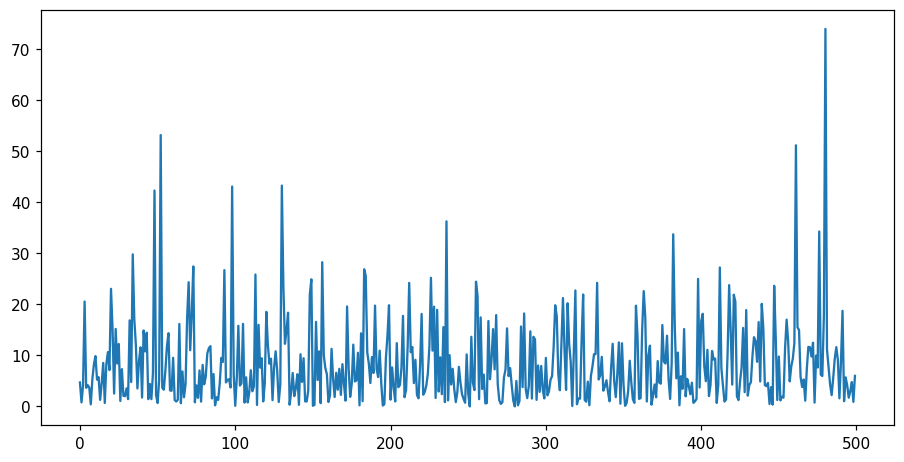

In [76]:
loss_history = pd.Series(losses)
loss_history.plot()

In [144]:
model.eval()
with torch.no_grad():
    id_scores = torch.linalg.norm(model(x_batch).reshape(x_batch.shape[0],-1), dim=-1).cpu()
    ood_scores = torch.linalg.norm(model(ood_batch).reshape(ood_batch.shape[0],-1), dim=-1).cpu()
id_scores.shape, ood_scores.shape

(torch.Size([16]), torch.Size([16]))

In [145]:
df = pd.DataFrame.from_dict({"Inlier":id_scores, "Outlier":ood_scores})
df.head()


,Inlier,Outlier
0,0.523043,65.004921
1,0.591722,123.841461
2,0.991572,39.952103
3,0.677178,26.160568
4,0.752892,46.747349


<AxesSubplot:ylabel='Frequency'>

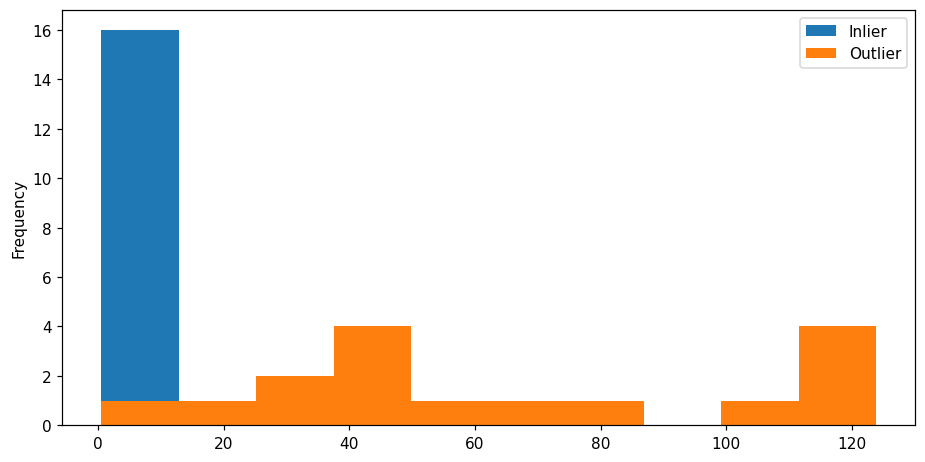

In [146]:
df.plot(kind="hist")